<a href="https://colab.research.google.com/github/caxaxa/PhD_Empirics/blob/main/Bayesian_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!mkdir Data
!mkdir Plottings
!wget https://raw.githubusercontent.com/caxaxa/PhD_Empirics/main/Data/Corruption.pkl

--2022-04-05 15:06:06--  https://raw.githubusercontent.com/caxaxa/PhD_Empirics/main/Data/Corruption.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979226 (956K) [application/octet-stream]
Saving to: ‘Corruption.pkl’

Corruption.pkl      100%[===================>] 956.28K  --.-KB/s    in 0.03s   

2022-04-05 15:06:06 (29.2 MB/s) - ‘Corruption.pkl’ saved [979226/979226]



In [3]:
df_corruption = pd.read_pickle('./Corruption.pkl')

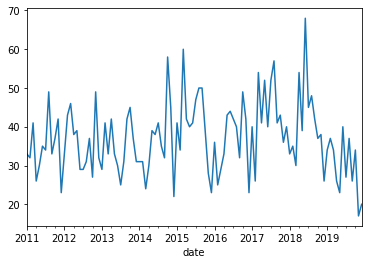

In [4]:
df_corruption.sort_index()['2011':'2019'].resample('M').title.count().plot()

In [5]:
#Yearly Variables
#Creating the yearly dataframe 
ydf = df_corruption['2011':'2019'].resample('Y').count()

ydf['cons'] = 1 


# creat a dummy with 0 before 2013 and 1 after #
dummy = []   
for i in (range(2010,2019)):
    if i < 2014:
        dummy.append(0)
    else:
        dummy.append(1)
        
ydf['dummy'] = dummy
ydf['year'] = range(2011,2020,1)
# creat a list of 1 to 10#
yt1 = list(range(1,10)) 

ydf['t1'] = yt1


# creat a polynomial root after 2013#
yt2= []                  # creat a polynom root after 2013#
for i in (range(2010,2019)):
    if i < 2015:
        yt2.append(0)
    else:
        yt2.append(i-2015)
ydf['t2'] = yt2
        
# Creating the higher order polynoms       
             
ydf['s1'] = np.power(yt1,2)
ydf['c1'] = np.power(yt1,3)
ydf['s2'] = np.power(yt2,2)
ydf['c2'] = np.power(yt2,3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#Monthly

mdf = df_corruption['2011':'2019'].resample('M').count()

#create a constant

mdf['cons'] = 1


# creat a dummy with 0 before feb 2014 (x months) and 1 after # Change this to better fit###
intervention = 42

dummy = []    
for i in (range(0,len(mdf))):
    if i <intervention:
        dummy.append(0)
    else:
        dummy.append(1)
        
mdf['dummy'] = dummy

# creat a list of 1 to 13#
t1 = list(range(0,len(mdf)))  

mdf['t1'] = t1

# creat a polynom root after 2013#
t2= []                  
for i in (range(0,len(mdf))):
    if i < intervention:
        t2.append(0)
    else:
        t2.append(i-intervention)
        
mdf['t2'] = t2

#Creating other orther polynomials
        
mdf['s1'] = np.power(t1,2)
mdf['c1'] = np.power(t1,3)
mdf['s2'] = np.power(t2,2)
mdf['c2'] = np.power(t2,3)
mdf['q1'] = np.power(t1,4)
mdf['f1'] = np.power(t1,5)
mdf['q2'] = np.power(t2,4)
mdf['f2'] = np.power(t2,5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
import pymc3 as pm
import arviz as az

## Parametric Bayesian Simple Regression

$$ y_i = \beta_0 + \beta_i x_i + ϵ_i$$
$$ \epsilon \tilde N (0, \sigma ) $$

Given the following prioirs:

$$ \beta_0 \beta_1 \tilde (0,50)$$
$$ \sigma |\tilde| (50)$$ 

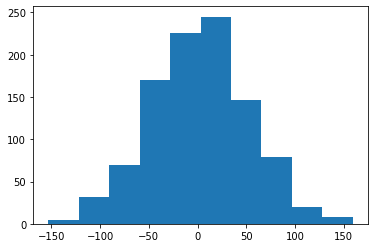

In [8]:
a_normal_distribution = pm.Normal.dist(mu=0, sigma=50)
plt.hist(a_normal_distribution.random(size=1000));

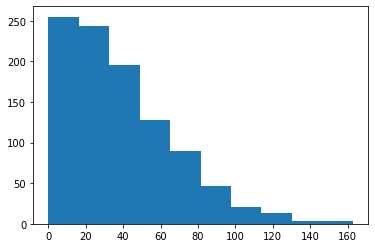

In [9]:
a_half_normal_distribution = pm.HalfNormal.dist(sigma=50)
plt.hist(a_half_normal_distribution.random(size=1000));

In [10]:
x, y = mdf[['t1', 'offences']].values.T

In [13]:
with pm.Model() as linear_model:
    
    β = pm.Normal('β', mu=0, sigma=50, shape=2)
    σ = pm.HalfNormal('σ', sigma=50)
    
    μ = β[0] + β[1] * x
    
    recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

In [14]:
with linear_model:
    
    linear_trace = pm.sample(1000, tune=2000, cores=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 8 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


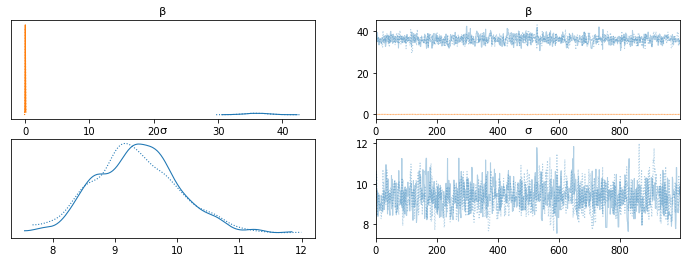

In [15]:
az.plot_trace(linear_trace);

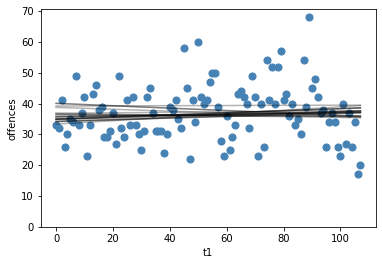

In [20]:
X_pred = np.linspace(0, 107, 100)

ax = mdf.plot.scatter(x='t1', y='offences', c='steelblue', s=50)
ax.set_ylim(0, None)
for b0,b1 in linear_trace['β'][:20]:
    ax.plot(X_pred, b0 + b1*X_pred, alpha=0.3, color='black');

## Quadratic model

In [21]:
with pm.Model() as quad_salmon_model:
    
    β = pm.Normal('β', mu=0, sigma=50, shape=3)
    σ = pm.HalfNormal('σ', sigma=50)
    
    μ = β[0] + β[1] * x + β[2] * x**2
    
    recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

In [22]:
with quad_salmon_model:
    
    quad_trace = pm.sample(1000, tune=2000, cores=2, random_seed=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 38 seconds.
The acceptance probability does not match the target. It is 0.8876102601257247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867322534034772, but should be close to 0.8. Try to increase the number of tuning steps.


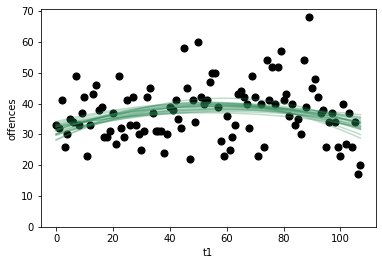

In [23]:
ax = mdf.plot.scatter(x='t1', y='offences', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1,b2 in quad_trace['β'][:20]:
    ax.plot(X_pred, b0 + b1*X_pred + b2*X_pred**2, alpha=0.3, color='seagreen');

## Gaussian Process

In [34]:
with pm.Model() as gp_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(mdf.t1/mdf.offences).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    X_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    X_gp.marginal_likelihood('offences', X=mdf.offences.values.reshape(-1,1), 
                           y=mdf.t1.values, noise=σ)

In [35]:
with gp_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 148 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


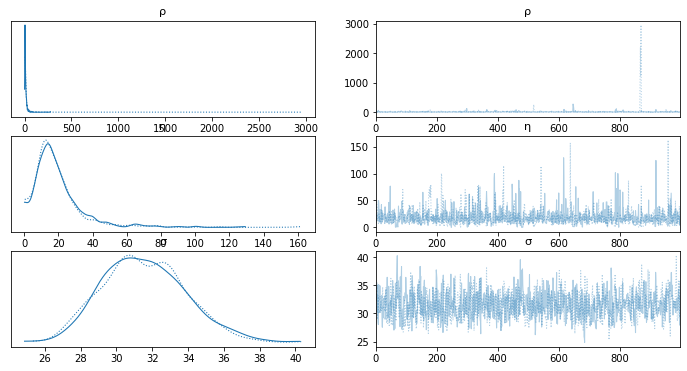

In [36]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [37]:
with gp_model:
    y_pred = X_gp.conditional("Offences_Pred", X_pred.reshape(-1, 1))
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[y_pred], samples=3, random_seed=42)

TypeError: ignored